# Model flow on comp_data_household 


## Import packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from earthquake_damage.ml_logic.preprocessor import cus_imputation, preprocess_features, preprocess_targets
from earthquake_damage.data.main import train_test_val

## Imputation and preprocess the data 

In [249]:
cus_imputation(filename = 'comp_data_household')


Imputation...

✅  There are 26 vaules missing in the dataset.

✅ df_imputed, with shape (747137, 44)
✅ df_imputed saved to /Users/chantalwuerschinger/code/chantalwuer/earthquake_damage/processed_data/df_imputed.csv


In [259]:
# preprocess_features()
preprocess_targets()


Preprocess target...

✅ y processed, with shape (747137,)
✅ y_processed saved to /Users/chantalwuerschinger/code/chantalwuer/earthquake_damage/processed_data/y_processed.csv


In [263]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val()

## Check data statistics

In [7]:
X.isna().sum().sum()

0

In [8]:
X.duplicated().sum()

0

In [9]:
y.value_counts()

damage_grade
4               276274
3               181467
2               132168
1                83609
0                73619
dtype: int64

## PCA on dimensionality reduction 
### The accuracy & f1_micro score is better without PCA 

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)


In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_pca, y_train)


KNeighborsClassifier()

In [30]:
X_val_pca = pca.transform(X_val)
y_val_pred_pca = knn.predict(X_val_pca)


In [31]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_val, y_val_pred_pca)

0.3802300040908671

In [32]:
knn.fit(X_train, y_train)
y_val_pred = knn.predict(X_val)

In [33]:
balanced_accuracy_score(y_val, y_val_pred)

0.4038442715541331

In [34]:
from sklearn.metrics import f1_score

print('f1-micro with pca',f1_score(y_test, y_val_pred_pca, average='micro'))
print('f1-micro without pca',f1_score(y_test, y_val_pred, average='micro'))


f1-micro with pca 0.25027884109180787
f1-micro without pca 0.2532412488511747


In [14]:
from sklearn.metrics import f1_score
f1_score(y_val, y_val_pred, average='micro')

0.5820506643110172

### Use model.feature_importances_ to select features is better than selectpercentile method

In [123]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_jobs=-1)

xgb_model.fit(X_train, y_train)

y_val_pred = xgb_model.predict(X_val)


In [128]:
pd.set_option('display.max_rows', None)
a = pd.DataFrame(xgb_model.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False)
model_feature = a.head(76).index
model_feature 

Index(['pipeline-1__has_superstructure_mud_mortar_stone',
       'pipeline-1__district_id',
       'pipeline-2__foundation_type_Mud mortar-Stone/Brick',
       'pipeline-2__ground_floor_type_RC',
       'pipeline-1__has_superstructure_stone_flag',
       'pipeline-2__roof_type_RCC/RB/RBC', 'pipeline-1__vdcmun_id',
       'pipeline-2__other_floor_type_TImber/Bamboo-Mud', 'pipeline-1__ward_id',
       'pipeline-1__has_superstructure_cement_mortar_brick',
       'pipeline-1__has_superstructure_adobe_mud',
       'pipeline-2__foundation_type_RC', 'pipeline-1__household_id',
       'pipeline-1__has_superstructure_mud_mortar_brick',
       'pipeline-1__has_superstructure_rc_engineered',
       'pipeline-2__other_floor_type_Not applicable',
       'pipeline-2__foundation_type_Bamboo/Timber',
       'pipeline-2__ground_floor_type_Timber',
       'pipeline-1__has_superstructure_timber',
       'pipeline-2__roof_type_Bamboo/Timber-Light roof',
       'pipeline-1__has_secondary_use', 'pipeline-2_

In [129]:
xgb_model.fit(X_train[model_feature], y_train)

y_val_pred_model_feature = xgb_model.predict(X_val[model_feature])

f1_score(y_val, y_val_pred_model_feature, average='micro')

0.5820238955662036

### Use SelectPrecentile to select top 8 features from the dataset

# GridSearch best parameter for XGBoostclassifier

In [135]:
from sklearn.model_selection import GridSearchCV 
import warnings
warnings.filterwarnings('ignore')


In [136]:
grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.3, 0.5,1],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [137]:
model = XGBClassifier(n_jobs=-1, n_estimators=100, random_state=42)
search = GridSearchCV(model, grid, scoring="f1_micro", n_jobs=-1, cv=3, verbose=1)


In [138]:
search.fit(X_train[model_feature], y_train) 

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5], 'gamma': [0, 0.25, 1],
                         'learning_rate': [0.1, 0.3, 0.5, 1],
                         'max_depth': [3, 4, 5, 7], 'reg_lambda': [0, 1, 10],
                         'subsample': [0.8]},
             scoring='f1_micro', verbose=1)

In [140]:
search.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 1,
 'max_depth': 7,
 'reg_lambda': 10,
 'subsample': 0.8}

In [141]:
search.best_score_

0.5925735434158835

In [142]:
search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [ ]:
best_model = XGBClassifier(n_jobs=-1, n_estimators=100, random_state=42, colsample_bytree=0.5,
    gamma=0, learning_rate=1, max_depth=7, reg_lambda=10, subsample=0.8)
best_model.fit(X_train[model_feature], y_train) 

In [ ]:
y_val_best = best_model.predict(X_val[model_feature])
f1_score(y_val, y_val_best, average='micro') 

In [168]:
X_train[model_feature].shape
X_val[model_feature].shape

(112071, 76)

# Build a neural network

### Reload Data

In [120]:
# data = pd.read_csv('/Users/chantalwuerschinger/code/chantalwuer/earthquake_damage/processed_data/comp_data_household.csv')
data = pd.read_csv('/Users/chantalwuerschinger/code/chantalwuer/earthquake_damage/processed_data/comp_data_household.csv')


In [226]:
data.dropna(inplace=True)

In [121]:
data.head()

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,land_surface_condition,foundation_type,roof_type,ground_floor_type,...,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,household_id,gender_household_head,age_household_head,education_level_household_head,income_level_household,size_household
0,120101000011,12,1207,120703,1,9,Flat,Other,Bamboo/Timber-Light roof,Mud,...,0,0,0,0,12010100001101,Male,31.0,Illiterate,Rs. 10 thousand,3.0
1,120101000021,12,1207,120703,1,15,Flat,Other,Bamboo/Timber-Light roof,Mud,...,0,0,0,0,12010100002101,Female,62.0,Illiterate,Rs. 10 thousand,6.0
2,120101000031,12,1207,120703,1,20,Flat,Other,Bamboo/Timber-Light roof,Mud,...,0,0,0,0,12010100003101,Male,51.0,Illiterate,Rs. 10 thousand,13.0
3,120101000041,12,1207,120703,1,20,Flat,Other,Bamboo/Timber-Light roof,Mud,...,0,0,0,0,12010100004101,Male,48.0,Illiterate,Rs. 10 thousand,5.0
4,120101000051,12,1207,120703,1,30,Flat,Other,Bamboo/Timber-Light roof,Mud,...,0,0,0,0,12010100005101,Male,70.0,Illiterate,Rs. 10 thousand,8.0


In [227]:
X = data.drop(columns=['damage_grade', 'building_id'])
y = data['damage_grade']

In [228]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder

le = LabelEncoder()
y_processed = le.fit_transform(y)

In [222]:
np.unique(y_processed)

array([0, 1, 2, 3, 4])

In [230]:
from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(
    y_processed, num_classes=5
)
print(y_cat)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [202]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer

num_transformer = make_pipeline(RobustScaler())
num_col = make_column_selector(dtype_include=['int64', 'float64'])

cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
cat_col = make_column_selector(dtype_include=['object'])

preprocessor = make_column_transformer((num_transformer, num_col),
                                            (cat_transformer, cat_col),
                                            remainder='passthrough')

In [231]:
X_processed = preprocessor.fit_transform(X)

# Save data
X_processed = pd.DataFrame(X_processed)
X_processed.columns = preprocessor.get_feature_names_out()

In [204]:
X_processed.shape

(747137, 85)

### Build Network

In [55]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import layers

In [107]:
X_train.shape[1:]

(83,)

In [268]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)
y_val_cat = to_categorical(y_val, num_classes=5)

In [314]:
def init_model():
    model = Sequential()
    
    # model.add(layers.Dense(10, input_dim=X_train.shape[1], activation='relu'))
    model.add(layers.Dense(50, input_dim=X_train.shape[1], activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Accuracy', 'Precision', 'Recall'])
    
    return model

In [315]:
model = init_model()
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 50)                4200      
                                                                 
 dense_83 (Dense)            (None, 20)                1020      
                                                                 
 dropout_4 (Dropout)         (None, 20)                0         
                                                                 
 dense_84 (Dense)            (None, 5)                 105       
                                                                 
Total params: 5,325
Trainable params: 5,325
Non-trainable params: 0
_________________________________________________________________


In [316]:
es = EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train_cat, 
          epochs=100, batch_size=32, verbose=1,
          callbacks=[es], validation_data=(X_val, y_val_cat))


Epoch 1/100
16344/16344 [==============================] - 21s 1ms/step - loss: 1.2320 - Accuracy: 0.4658 - precision: 0.6437 - recall: 0.2173 - val_loss: 1.1743 - val_Accuracy: 0.4842 - val_precision: 0.6932 - val_recall: 0.2525
Epoch 2/100
16344/16344 [==============================] - 19s 1ms/step - loss: 1.1862 - Accuracy: 0.4818 - precision: 0.6847 - recall: 0.2440 - val_loss: 1.1653 - val_Accuracy: 0.4898 - val_precision: 0.7017 - val_recall: 0.2538
Epoch 3/100
16344/16344 [==============================] - 21s 1ms/step - loss: 1.1787 - Accuracy: 0.4855 - precision: 0.6910 - recall: 0.2484 - val_loss: 1.1581 - val_Accuracy: 0.4938 - val_precision: 0.6969 - val_recall: 0.2641
Epoch 4/100
16344/16344 [==============================] - 21s 1ms/step - loss: 1.1747 - Accuracy: 0.4881 - precision: 0.6921 - recall: 0.2498 - val_loss: 1.1562 - val_Accuracy: 0.4942 - val_precision: 0.6874 - val_recall: 0.2731
Epoch 5/100
16344/16344 [==============================] - 19s 1ms/step - loss: 

In [318]:
history.history.keys()

dict_keys(['loss', 'Accuracy', 'precision', 'recall', 'val_loss', 'val_Accuracy', 'val_precision', 'val_recall'])

In [319]:
def plot_history(history):
    plt.plot(history.history['Accuracy'])
    plt.plot(history.history['val_Accuracy'])
    plt.title('Model Loss')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    # plt.ylim(0, .4)
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

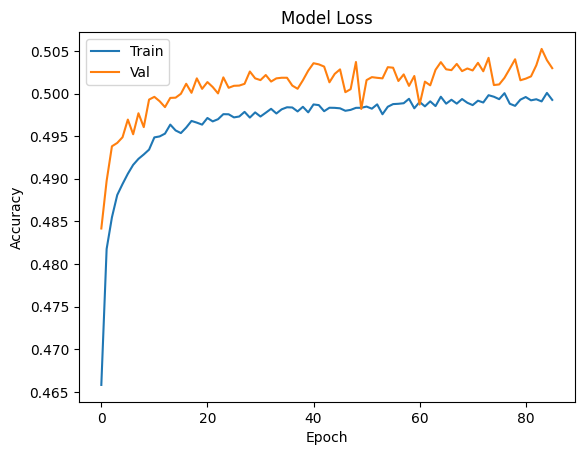

In [320]:
plot_history(history)

In [321]:
results_test = model.evaluate(X_test, y_test_cat)
results_test

3503/3503 [==============================] - 6s 2ms/step - loss: 1.1344 - Accuracy: 0.5046 - precision: 0.7114 - recall: 0.2710


[1.1343718767166138, 0.5046176314353943, 0.711438000202179, 0.2710067629814148]